# Bring Your Own COG with `sentinelhub-py`

Sentinel Hub allows you to access your own data stored in your S3 bucket with the powerful Sentinel Hub API. Since data remains on your bucket, you keep full control over it. This functionality requires no replication of data and allows you to exercise the full power of the Sentinel Hub service including Custom algorithms. [More information here!](https://www.sentinel-hub.com/bring-your-own-data/)

The [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/) has a very user-friendly "Bring your own COG" tab. If you are not going to be creating collections, adding/updating collection tiles, etc. daily, the Dashboard tool is your friend. For the rest, this tutorial is a simple walk-through on creating, updating, listing, and deleting your BYOC collections through Python using `sentinelhub-py`.

Some general imports:

In [1]:
%matplotlib inline

import numpy as np
import datetime as dt
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from sentinelhub import SHConfig, DataCollection, Geometry, BBox, CRS, \
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType

Imports that related to BYOC functionality:

In [2]:
from sentinelhub import SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData

## Prerequisites

BYOC API requires Sentinel Hub account. Please see [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) how to set up your configuration.

In [3]:
config = SHConfig()

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub BYOC API, please provide the credentials (client ID and client secret).")

## BYOC collections

`SentinelHubBYOC` class holds the methods for interacting with Sentinel-Hub services. Let's initialize it with our `config`:

In [4]:
byoc = SentinelHubBYOC(config=config)

### Get a list of your collections

If you already have some BYOC collections, you can retrieve them with the following command

In [5]:
collections_iterator = byoc.iter_collections()

Let's have a look at my (first) collection

In [6]:
my_collection = next(collections_iterator)

# if you prefer to work with dataclasses, you can also do
# my_collection = ByocCollection.from_dict(next(collection_iterator))

One can of course retrieve all of them in one go like so:

```Python
my_collections = list(collections_iterator)
```

In [7]:
my_collection['name']

# or `my_collection.name` when using dataclass

'Sentinel S2 L2A Mosaic 120m'

My first collection is the ["Sentinel S2 L2A Mosaic 120"](https://github.com/sentinel-hub/public-collections/tree/main/collections/sentinel-s2-l2a-mosaic-120) collection. You can read more about that particular collection (and how to "adopt" it) [here](https://medium.com/sentinel-hub/digital-twin-sandbox-sentinel-2-collection-available-to-everyone-20f3b5de846e). 

In [8]:
my_collection

{'id': '0074520d-bcf5-4811-8f6f-afd946e77695',
 'userId': '1b639ce6-eb3e-494c-9cb4-2eab3569b121',
 'name': 'Sentinel S2 L2A Mosaic 120m',
 's3Bucket': 'sentinel-s2-l2a-mosaic-120',
 'additionalData': {'bands': {'B02': {'bitDepth': 16},
   'B03': {'bitDepth': 16},
   'B04': {'bitDepth': 16},
   'B08': {'bitDepth': 16},
   'B11': {'bitDepth': 16},
   'B12': {'bitDepth': 16},
   'dataMask': {'bitDepth': 8}},
  'maxMetersPerPixel': 9600.0,
  'maxMetersPerPixelOverride': 20000.0},
 'created': '2021-01-16T18:44:36.720Z'}

A useful way for managing your collections is `pandas.DataFrame` you can create like so:

In [9]:
my_collections = pd.DataFrame(data=list(byoc.iter_collections()))

In [10]:
my_collections[['id','name','created']].head(1)

,id,name,created
0,0074520d-bcf5-4811-8f6f-afd946e77695,Sentinel S2 L2A Mosaic 120m,2021-01-16T18:44:36.720Z


### Update existing collection

Anything you can do on Dashboard, Bring your own COG tab, you can do programmatically as well. Updating collection name is a breeze:

In [11]:
my_collection['name'] = 'Digital Twin Earth @120m'

# my_collection.name = 'Digital Twin Earth @120m' when using dataclass

Note that while you can change other fields as well, `s3_bucket` cannot be changed, and the `bitDepth` of bands in the collection is something that is pertinent to the COGs themselves and populated during the ingestion.

To update the collection, call:

In [12]:
byoc.update_collection(my_collection)

### Create new collection

The easiest way to create a collection is to use its dataclass:

In [13]:
new_collection = ByocCollection(name='new collection', s3_bucket='my-s3-bucket')

The "new collection" is accessible on `my_bucket` s3 bucket (please see how to configure your bucket for Sentinel-Hub service [here](https://docs.sentinel-hub.com/api/latest/data/byoc/#aws-bucket-settings)).

The call to create the collection on Sentinel-Hub, will return newly created collection, which will get its own collection id:

In [14]:
created_collection = byoc.create_collection(new_collection)

In [15]:
created_collection['id']

'6b99104b-a728-4821-b1f0-37309642e7e9'

### Delete collection

If you are the owner of the collection, you can also delete it. 

<div class="alert alert-warning">

**Warning:**
    
Beware! Deleting the collection will also delete all its tiles!
</div>

In [16]:
byoc.delete_collection(created_collection)

# or just pass the collection id: byoc.delete_collection('73779a19-2744-487c-9416-a6660bf8634e')

''

Trying to access this collection now will fail

In [17]:
from sentinelhub import DownloadFailedException

try: 
    deleted_collection = byoc.get_collection(created_collection['id'])
except DownloadFailedException as e:
    print(e)

Failed to download from:
https://services.sentinel-hub.com/api/v1/byoc/collections/6b99104b-a728-4821-b1f0-37309642e7e9
with HTTPError:
404 Client Error: Not Found for url: https://services.sentinel-hub.com/api/v1/byoc/collections/6b99104b-a728-4821-b1f0-37309642e7e9
Server response: "{"error":{"status":404,"reason":"Not Found","message":"Collection 6b99104b-a728-4821-b1f0-37309642e7e9 not found.","code":"COMMON_NOT_FOUND"}}"


## BYOC tiles (cogs in the collection)

Your data needs to be organized into collections of tiles. Each tile needs to contain a set of bands and (optionally) an acquisition date and time. Tiles with the same bands can be grouped into collections. Think of the Sentinel-2 data source as a collection of Sentinel-2 tiles. 

Tiles have to be on an s3 bucket and need to be in COG format. We will not go into details about the COGification process; users can have a look at the [documentation](https://docs.sentinel-hub.com/api/latest/data/byoc/#converting-to-cog) or use the [BYOC tool](https://docs.sentinel-hub.com/api/latest/data/byoc/#sentinel-hub-byoc-tool) that will take care of creating a collection and ingesting the tiles for you.

### Getting tiles from your collection

Let's have a look at a tile

In [18]:
tile = next(byoc.iter_tiles(my_collection))

# possibly convert it to ByocTile dataclass
# tile = ByocTile.from_dict(tile)

In [19]:
tile

{'id': '000669c5-19da-4f57-bbed-af036b272530',
 'created': '2021-01-22T09:57:07.000',
 'sensingTime': '2019-11-27T00:00:00.000',
 'coverGeometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::32628'}},
  'coordinates': [[[[299999.9970628682, 7100040.000814738],
     [299999.9978952622, 6935280.000743836],
     [326999.99924417154, 6930480.000699763],
     [309239.9985182455, 6925080.000720168],
     [339839.9995705106, 6917400.000688601],
     [323159.9991567135, 6907920.000696774],
     [338039.99955105875, 6900000.000684933],
     [364919.99987387564, 6900120.000679002],
     [353159.9997665596, 6916320.000684405],
     [400079.99998470914, 6899880.0006782515],
     [400079.9999813677, 6999960.000700505],
     [600120.0000188947, 6999960.000700505],
     [600120.0000231846, 7100040.000720726],
     [299999.9970628682, 7100040.000814738]]]]},
 'tileGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 

In [20]:
list(tile.keys())

['id',
 'created',
 'sensingTime',
 'coverGeometry',
 'tileGeometry',
 'path',
 'status',
 'additionalData']

The most important field of the tile is its `path` on an s3 bucket. For example, if your band files are stored in `s3://bucket-name/folder/`, then set `folder` as the tile path. In this case, the band names will equal the file names. For example, the band B1 corresponds to the file `s3://bucket-name/folder/B1.tiff`.

If your file names have something other than just the band name, such as a prefix, this is fine as long as the prefix is the same for all files. In this case, the path needs to include this prefix and also the band placeholder: `(BAND)`. Adding the extension is optional. For example, this is what would happen if you would use the following path `folder/tile_1_(BAND)_2019.tiff` for the following files:

   * `s3://bucket-name/folder/tile_1_B1_2019.tiff` - the file would be used, the band name would be B1
   * `s3://bucket-name/folder/tile_1_B2_2019.tiff` - the file would be used, the band name would be B2
   * `s3://bucket-name/folder/tile_2_B1_2019.tiff` - the file would not be used
   * `s3://bucket-name/folder/tile_2_B2_2019.tiff` - the file would not be used
   
Optionally, set the `sensingTime` to make the collection "temporal". 

Do not forget that adding multiple tiles will work only if these tiles have the same bands (with different data of course).

As we can see, the `tile` object has several fields about geometry. `tileGeometry` is the bounding box of the tile, while the (optional) `coverGeometry` is the geometry of where the data (within the bounding box) is. For a good explanation of the `coverGeometry` please see [docs](https://docs.sentinel-hub.com/api/latest/data/byoc/#a-note-about-cover-geometries).

### Visualizing the tiles in your collection

Using `ByocTile` dataclass, which will properly parse tile geometries, date-time strings, etc., one can create a `geopandas.GeoDataFrame`. 

_Note: the geometries can be in different coordinate reference systems, so a transform to a common CRS might be needed._

In [21]:
tile_iterator = byoc.iter_tiles(my_collection)

In [22]:
tiles = []
for i in range(100):
    tiles.append(ByocTile.from_dict(next(tile_iterator)))

tiles_gdf = gpd.GeoDataFrame(tiles, geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles], crs='epsg:4326')

In [23]:
tiles_gdf.head()

,path,other_data,status,tile_id,tile_geometry,cover_geometry,created,sensing_time,additional_data,geometry
0,2019/11/27/28V/(BAND).tif,{},INGESTED,000669c5-19da-4f57-bbed-af036b272530,"Geometry(POLYGON ((300000 7100040, 600120 7100...",Geometry(MULTIPOLYGON (((299999.9970628682 710...,2021-01-22 09:57:07,2019-11-27,"{'bandHeaderSizes': {'B02': 1328, 'B03': 1328,...","MULTIPOLYGON (((-19.08666 63.96961, -18.88321 ..."
1,2019/4/21/29U/(BAND).tif,{},INGESTED,000de4c1-5924-4001-a11f-de97fd66b738,"Geometry(POLYGON ((399960 6200040, 800040 6200...",Geometry(MULTIPOLYGON (((399959.9999960825 610...,2021-01-22 09:57:11,2019-04-21,"{'bandHeaderSizes': {'B02': 1774, 'B03': 1774,...","MULTIPOLYGON (((-10.56542 55.03746, -10.41188 ..."
2,2019/8/19/41X/(BAND).tif,{},INGESTED,0014c5c3-e771-4774-aa3e-7394b7fedb92,"Geometry(POLYGON ((600000 8100000, 700080 8100...",Geometry(MULTIPOLYGON (((600000.0002175444 799...,2021-01-22 10:03:58,2019-08-19,"{'bandHeaderSizes': {'B02': 916, 'B03': 916, '...","MULTIPOLYGON (((65.91238 72.07682, 68.81280 72..."
3,2019/11/27/20Q/(BAND).tif,{},INGESTED,0015a361-1f5e-4cb8-9b58-422254dfa13a,"Geometry(POLYGON ((199980 2100000, 300060 2100...",Geometry(MULTIPOLYGON (((199979.9999253317 189...,2021-01-22 09:56:36,2019-11-27,"{'bandHeaderSizes': {'B02': 1106, 'B03': 1106,...","MULTIPOLYGON (((-65.82012 17.16474, -64.87985 ..."
4,2019/1/21/51H/(BAND).tif,{},INGESTED,0016c1f8-00c9-497b-8a4c-c806bca71414,"Geometry(POLYGON ((199980 6500020, 800100 6500...",Geometry(MULTIPOLYGON (((199979.9995848495 650...,2021-01-22 10:04:47,2019-01-21,"{'bandHeaderSizes': {'B02': 1662, 'B03': 1662,...","MULTIPOLYGON (((119.83821 -31.59585, 119.70479..."


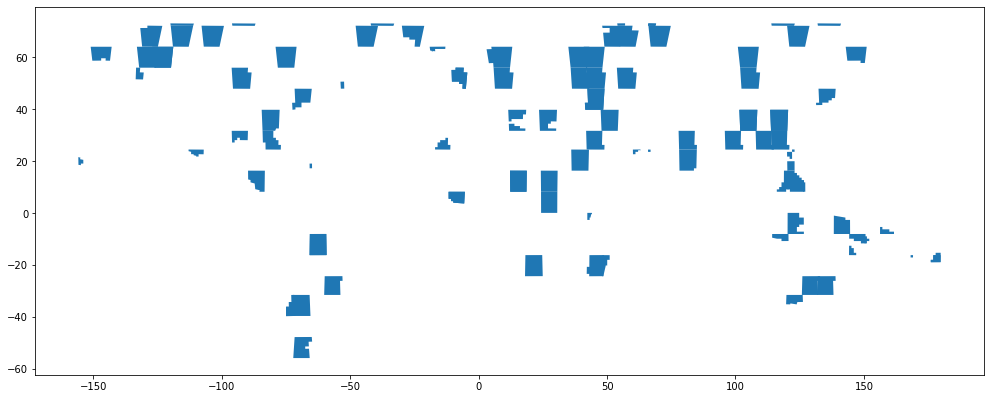

In [24]:
fig, ax = plt.subplots(figsize=(17,8))
tiles_gdf.plot(ax=ax);

In the above example, the collection has a lot of tiles (namely, 19869), so we've limited ourselves to only retrieving 100 tiles, hence the tiles are so sparse in the image above.

### Updating and deleting a tile

Updating and deleting a tile follow the same logic as updating/deleting a collection:

To delete a tile:
```python
# collection id and tile id are sufficient to delete it
byoc.delete_tile(collection, tile) 
```

To update a tile:
```python
tile['sensing_time'] = '2020-01-01T10:15:12'
byoc.update_tile(collection, tile)
```

### Creating a new tile (and ingesting it to collection)

When we create a new tile and add it to the collection, the ingestion process on the Sentinel-Hub side will happen, checking if the tile corresponds to the COG specifications as well as if it conforms to the collection. 

The response from `byoc.create_tile` has a valid `id`, and its `status` is set to `WAITING`. Checking the tile `status` after a while (by requesting this tile) will tell you if it has been `INGESTED` or if the ingestion procedure `FAILED`. In case of failure, additional information (with the cause of failure) will be available in the tile `additional_data`.  

The simplest way to create a new tile is by using the `ByocTile` dataclass, which will complain if the required fields are missing. 

In [25]:
bbox = BBox((21.6,55.4,22.7,55.6), crs=CRS.WGS84)

new_tile = ByocTile(path='path on s3 bucket, required field', 
                    sensing_time=dt.datetime(2021, 2, 15, 11, 10, 15), #optional field
                    tile_geometry=Geometry(bbox.geometry, bbox.crs),   #optional field, will be read from COG file 
                    cover_geometry=None                                #optional field, useful for optimized search
                                                                       #                can be a Geometry created from shapely.polygon and crs, for instance
                   )

Adding this tile to a collection is then done by

```python
created_tile = byoc.create_tile(collection, new_tile)
```

## Retrieving data from collection

Once we have a collection created and its tiles ingested, we can retrieve the data from said collection.

We will be using ProcessAPI for this.

In [26]:
data_collection = DataCollection.define_byoc(my_collection['id'])

# or using dataclass:
# data_collection = my_collection_dataclass.to_data_collection()

In [27]:
tile_time = dt.datetime.fromisoformat(tile['sensingTime'])

# or from dataclass simply
# tile_time = tile_dataclass.sensing_time

In [29]:
caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)

In [30]:
false_color_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08","B04","B03", "dataMask"],
    output: { bands: 4 },
  };
}

var f = 2.5/10000;
function evaluatePixel(sample) {
  return [f*sample.B08, f*sample.B04, f*sample.B03, sample.dataMask];
}
"""

request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=tile_time
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=caspian_sea_bbox,
        size=bbox_to_dimensions(caspian_sea_bbox, 100),
        config=config
    )

In [31]:
data = request.get_data()[0]

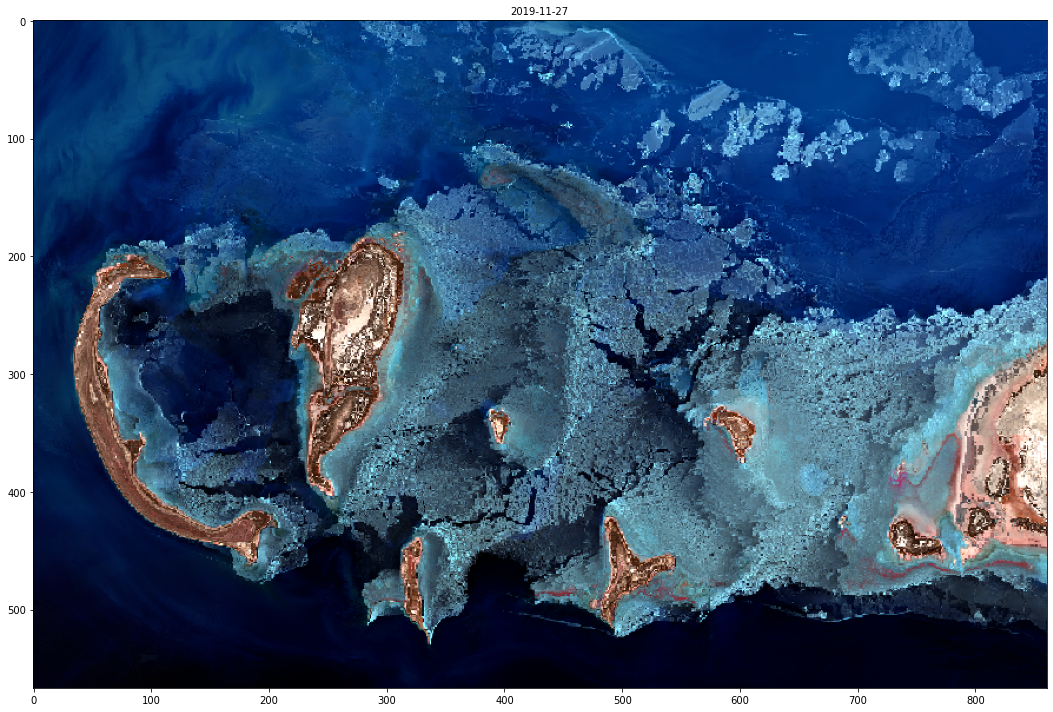

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(data)
ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()